# Outlier Detection

In [1153]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from collections import deque
import sys

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib

from sklearn.metrics import (
                            roc_curve,
                            auc, accuracy_score,
                            precision_score, 
                            recall_score,
                            f1_score
                            )
import tensorflow as tf
from pickle import dump

# !{sys.executable} -m pip install pyyaml
import yaml

# !{sys.executable} -m pip torch torchaudio torchvision
# import torch
# print(torch.__version__)
# print(torch.cuda.is_available())  # Verifica si se reconoce la GPU

# !{sys.executable} -m pip streamlit
# import streamlit

In [1185]:
!{sys.executable} -m pip install matplotlib

"c:\Users\SEBASTIAN\Documents\Github" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [1154]:
# 1. Función para cargar y limpiar los datos
def cargar_y_limpiar_datos(file_path):
    data = pd.read_excel(file_path, header=0)
    data = data.drop(['Total general (Número de pasajeros)'], axis=1)
    data['Día'] = pd.to_datetime(data['Día'], dayfirst=True)
    data.columns = [str(col) if isinstance(col, datetime.time) else col for col in data.columns]
    horas = [col for col in data.columns if ':' in col]
    return data, horas

# 2. Función para filtrar datos de una línea específica
def filtrar_por_linea(data, linea_servicio='línea a'):
    return data[data['Línea de Servicio'].str.lower() == linea_servicio]

# 3. Función para generar el DataFrame completo de fechas y agregar columnas adicionales
def generar_dataframe_completo(data_linea_a, start, end):
    fechas_2023 = pd.DataFrame({'Día': pd.date_range(start=start, end=end)})
    data_linea_a_full = pd.merge(fechas_2023, data_linea_a, on='Día', how='left')
    data_linea_a_full['Día de la Semana'] = data_linea_a_full['Día'].dt.day_name()
    data_linea_a_full.columns = [str(col) if isinstance(col, datetime.time) else col for col in data_linea_a_full.columns]
    return data_linea_a_full

# 4. Función para calcular el promedio estacional por día de la semana
def calcular_promedio_estacional(data, horas):
    return data.groupby('Día de la Semana')[horas].median().round(0)

# 5. Función para rellenar los valores faltantes
def rellenar_faltantes(data, promedio_estacional, horas):
    # Asegúrate de que 'Día' esté presente en el DataFrame
    if 'Día de la Semana' not in data.columns:
        raise ValueError("El DataFrame 'data' debe contener una columna llamada 'Día' que indique el día de la semana.")

    # Itera sobre las horas para rellenar los valores faltantes
    for hora in horas:
        if hora in data.columns:
            # Rellena los valores faltantes según el promedio estacional
            data[hora] = data.apply(
                lambda row: promedio_estacional.loc[row['Día de la Semana'], hora] if pd.isnull(row[hora]) else row[hora], axis=1
            )
        else:
            print(f"La columna {hora} no existe en el DataFrame, omitiendo...")
        
    data['Línea de Servicio'] = data['Línea de Servicio'].fillna(method='ffill') 

    return data

# 6. Función para eliminar tendencia y estacionalidad
def eliminar_tendencia_estacionalidad(data, horas):
    descomposiciones = {}
    for hora in horas:
        serie = data.set_index('Día')[hora].dropna()
        try:
            descomp_aditiva = seasonal_decompose(serie, model='additive', period=7)
            residuo_aditivo = descomp_aditiva.resid.dropna()
            mse_aditivo = np.mean(np.square(residuo_aditivo))
        except Exception as e:
            print(f"Error en descomposición aditiva para {hora}: {e}")
            mse_aditivo = np.inf
        try:
            descomp_multiplicativa = seasonal_decompose(serie, model='multiplicative', period=7)
            residuo_multiplicativa = descomp_multiplicativa.resid.dropna()
            mse_multiplicativa = np.mean(np.square(residuo_multiplicativa))
        except Exception as e:
            print(f"Error en descomposición multiplicativa para {hora}: {e}")
            mse_multiplicativa = np.inf

        if mse_aditivo < mse_multiplicativa:
            print(f"Usando descomposición aditiva para {hora}")
            descomposiciones[hora] = descomp_aditiva
        else:
            print(f"Usando descomposición multiplicativa para {hora}")
            descomposiciones[hora] = descomp_multiplicativa
    return descomposiciones

# 7. Función para detectar outliers usando el método IQR
def detectar_outliers_en_residuos(descomposiciones, umbral=1.5, data=None):
    outliers_matrix = pd.DataFrame(0, index=descomposiciones[list(descomposiciones.keys())[0]].resid.dropna().index, columns=descomposiciones.keys())
    for hora, descomposicion in descomposiciones.items():
        if hora != list(descomposiciones.keys())[-1]:
            residuo = pd.DataFrame(descomposicion.resid.dropna()).merge(data, on='Día', how='left')
            residuo.index = outliers_matrix.index
            for day in data['Día de la Semana'].unique():
                residuo_estacional = residuo[residuo['Día de la Semana'] == day][hora]
                Q1 = residuo_estacional.quantile(0.25)
                Q3 = residuo_estacional.quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - umbral * IQR
                upper_bound = Q3 + umbral * IQR
                outliers = ((residuo_estacional < lower_bound) | (residuo_estacional > upper_bound)).astype(int)
                outliers_matrix.loc[outliers.index, hora] = outliers

    # Columna que cuenta el número total de outliers por día
    outliers_matrix['Total_Outliers'] = outliers_matrix.sum(axis=1)
    
    # Columna que indica si existe al menos un outlier en alguna de las horas (1 si al menos uno, 0 si no) -> si hay mas de 1 (¿Una linea?, ¿Una hora influye en las demas?)
    outliers_matrix['Any_Outlier'] = (outliers_matrix['Total_Outliers'] > 0).astype(int)        
    
    return outliers_matrix

# 8. Función para graficar la proporción de días con outliers
def graficar_proporcion_outliers(data):
    proporcion_outliers = data['Hay_Outlier'].value_counts(normalize=True)
    plt.figure(figsize=(6,4))
    proporcion_outliers.plot(kind='bar', color=['blue', 'orange'], grid=True)
    plt.title('Proporción de días con al menos un outlier')
    plt.xlabel('Hay Outlier')
    plt.ylabel('Proporción')
    plt.xticks(ticks=[0, 1], labels=['No hay outliers', 'Hay al menos un outlier'], rotation=0)
    plt.ylim(0, 1)
    plt.show()

# Función para entrenar un autoencoder con mayor capacidad (32 -> 8 neuronas)
def entrenar_autoencoder(train_data_normalized, test_data_normalized, input_dim):
    # Input layer
    input_layer = tf.keras.layers.Input(shape=(input_dim,))
    
    # Encoder
    encoded = tf.keras.layers.Dense(16, activation='relu')(input_layer)
    encoded = tf.keras.layers.Dense(8, activation='relu')(encoded)
    encoded = tf.keras.layers.Dense(4, activation='relu')(encoded)
    
    # Decoder
    decoded = tf.keras.layers.Dense(8, activation='relu')(encoded)
    decoded = tf.keras.layers.Dense(16, activation='relu')(decoded)
    decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoded)
    
    # Construimos el modelo
    autoencoder = tf.keras.models.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mae')

    # Implementamos Early Stopping para prevenir sobreajuste
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Entrenamiento
    history = autoencoder.fit(train_data_normalized, train_data_normalized,
                              epochs=500, batch_size=32,
                              validation_data=(test_data_normalized, test_data_normalized),
                              callbacks=[early_stopping],
                              verbose=1)
    
    return autoencoder, history

# # Función para entrenar un autoencoder con mayor capacidad (32 -> 8 neuronas)
# class Autoencoder(torch.nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()

#         #Codificador
#         self.cod1 = torch.nn.Linear(in_features=20, out_features=16) # Entrada: 20 muestras
#         self.cod2 = torch.nn.Linear(in_features=16, out_features=8)
#         self.cod3 = torch.nn.Linear(in_features=8, out_features=4)
        
#         #Decodificador
#         self.dec1 = torch.nn.Linear(in_features=4, out_features=8)
#         self.dec2 = torch.nn.Linear(in_features=8, out_features=16)
#         self.dec3 = torch.nn.Linear(in_features=16, out_features=20) # Salida: 20 muestras
        
#     def forward(self, x):
#         x = torch.nn.functional.relu(self.cod1(x))
#         x = torch.nn.functional.relu(self.cod2(x))
#         x = torch.nn.functional.relu(self.cod3(x))
        
#         x = torch.nn.functional.relu(self.dec1(x))
#         x = torch.nn.functional.relu(self.dec2(x))
#         x = torch.sigmoid(self.dec3(x))
        
#         return x

# 10. Función para graficar la curva de entrenamiento
def graficar_curva_entrenamiento(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.title('Curva de Error durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida (MAE)')
    plt.grid(True)
    plt.legend()
    plt.savefig(f'./results/train_curve.png')
    plt.show()

# 11. Función para evaluar el modelo con curva ROC
def evaluar_autoencoder(autoencoder, test_data_normalized, test_data, scaler, outlier_labels, umbral):
    predicted_normalized = autoencoder.predict(test_data_normalized)
    predicted = scaler.inverse_transform(predicted_normalized)
    errors = np.mean(np.abs(test_data - predicted), axis=1)

    errors_normales = errors[outlier_labels == 0]
    threshold = errors_normales.mean() + umbral * errors_normales.std()

    return threshold, errors

In [1155]:
def graficar_casos_outliers_vs_normales(autoencoder, scaler, data_linea_a_full_outliers, horas_outliers_columns, n=11):
    # Selección de un caso sin outliers y un caso con outliers
    sin_outliers = data_linea_a_full_outliers[data_linea_a_full_outliers['Any_Outlier_outlier'] == 0].iloc[n]
    con_outliers = data_linea_a_full_outliers[data_linea_a_full_outliers['Any_Outlier_outlier'] == 1].iloc[n]

    # Convertir las columnas de las horas de datos reales y reconstruidos a arrays
    # Datos reales y reconstruidos para un caso sin outliers
    real_sin_outliers = sin_outliers[horas_outliers_columns].values
    reconstruido_sin_outliers = scaler.inverse_transform(autoencoder.predict(scaler.transform([real_sin_outliers])))[0]

    # Datos reales y reconstruidos para un caso con outliers
    real_con_outliers = con_outliers[horas_outliers_columns].values
    reconstruido_con_outliers = scaler.inverse_transform(autoencoder.predict(scaler.transform([real_con_outliers])))[0]

    # Identificar las horas que tienen outliers en el caso con outliers
    horas_con_outliers = [col for col in horas_outliers_columns if con_outliers[f"{col}_outlier"] == 1]

    # 2. Creación de los subplots
    plt.figure(figsize=(14, 6))

    # 2.1 Subplot para caso sin outliers
    plt.subplot(1, 2, 1)
    plt.plot(horas_outliers_columns, real_sin_outliers, label='Real', color='blue', marker='o')
    plt.plot(horas_outliers_columns, reconstruido_sin_outliers, label='Reconstruido', color='green', marker='x')
    plt.title('Caso sin Outliers')
    plt.xlabel('Hora')
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotar los xticks para que se vean mejor
    plt.ylabel('Afluencia de Pasajeros')
    plt.legend()

    # 2.2 Subplot para caso con outliers
    plt.subplot(1, 2, 2)
    plt.plot(horas_outliers_columns, real_con_outliers, label='Real', color='blue', marker='o')
    plt.plot(horas_outliers_columns, reconstruido_con_outliers, label='Reconstruido', color='green', marker='x')

    # Marcar las horas con outliers en rojo
    for hora_outlier in horas_con_outliers:
        index = horas_outliers_columns.index(hora_outlier)
        plt.scatter(hora_outlier, real_con_outliers[index], color='red', label='Outlier' if hora_outlier == horas_con_outliers[0] else "", zorder=5)

    plt.title('Caso con Outliers')
    plt.xlabel('Hora')
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotar los xticks para que se vean mejor
    plt.ylabel('Afluencia de Pasajeros')
    plt.legend()

    # Mostrar los subplots
    plt.tight_layout()
    plt.show()

In [1156]:
# 1. Cargar y limpiar los datos para el año 2019
file_path_2019 = './data/Afluencia_Metro_2019.xlsx'
data_2019, horas_2019 = cargar_y_limpiar_datos(file_path_2019)

# 1. Cargar y limpiar los datos para el año 2020
file_path_2020 = './data/Afluencia_Metro_2020.xlsx'
data_2020, horas_2020 = cargar_y_limpiar_datos(file_path_2020)

# 1. Cargar y limpiar los datos para el año 2021
file_path_2021 = './data/Afluencia_Metro_2021.xlsx'
data_2021, horas_2021 = cargar_y_limpiar_datos(file_path_2021)

# 1. Cargar y limpiar los datos para el año 2022
file_path_2022 = './data/Afluencia_Metro_2022.xlsx'
data_2022, horas_2022 = cargar_y_limpiar_datos(file_path_2022)

# 1. Cargar y limpiar los datos para el año 2023
file_path_2023 = './data/Afluencia_Metro_2023.xlsx'
data_2023, horas_2023 = cargar_y_limpiar_datos(file_path_2023)

# 1. Cargar y limpiar los datos para el año 2024
file_path_2024 = './data/Afluencia_Metro_2024.xlsx'
data_2024, horas = cargar_y_limpiar_datos(file_path_2024)

data_2024.head()

,Día,Línea de Servicio,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,2024-01-01,LÍNEA 1,180.0,858.0,886.0,721.0,659.0,820.0,952.0,1083.0,...,1418.0,1563.0,1734.0,2108.0,2352.0,1903.0,1676.0,1132.0,139.0,NaN
1,2024-01-01,LÍNEA 2,1.0,149.0,143.0,74.0,100.0,135.0,116.0,225.0,...,198.0,188.0,277.0,291.0,284.0,212.0,152.0,100.0,9.0,NaN
2,2024-01-01,LÍNEA A,1460.0,5488.0,5769.0,4752.0,3993.0,4512.0,5551.0,7197.0,...,10362.0,10666.0,12998.0,15376.0,16932.0,14537.0,11750.0,7729.0,664.0,NaN
3,2024-01-01,LÍNEA B,231.0,718.0,826.0,672.0,641.0,818.0,1060.0,1398.0,...,1741.0,1956.0,2228.0,2587.0,2749.0,2043.0,1302.0,893.0,85.0,NaN
4,2024-01-01,LÍNEA H,NaN,NaN,NaN,NaN,NaN,50.0,62.0,71.0,...,76.0,72.0,93.0,83.0,113.0,80.0,39.0,25.0,4.0,NaN


In [1157]:
# 2. Filtrar los datos para la LÍNEA A en 2019
data_linea_a_2019 = filtrar_por_linea(data_2019)

# 2. Filtrar los datos para la LÍNEA A en 2020
data_linea_a_2020 = filtrar_por_linea(data_2020)

# 2. Filtrar los datos para la LÍNEA A en 2021
data_linea_a_2021 = filtrar_por_linea(data_2021)

# 2. Filtrar los datos para la LÍNEA A en 2022
data_linea_a_2022 = filtrar_por_linea(data_2022)

# 2. Filtrar los datos para la LÍNEA A en 2023
data_linea_a_2023 = filtrar_por_linea(data_2023)

# 2. Filtrar los datos para la LÍNEA A en 2024
data_linea_a_2024 = filtrar_por_linea(data_2024)
data_linea_a_2024['Línea de Servicio'].unique()

array(['LÍNEA A'], dtype=object)

In [1158]:
len(data_linea_a_2019), len(data_linea_a_2020), len(data_linea_a_2021), len(data_linea_a_2022), len(data_linea_a_2023), len(data_linea_a_2024)

(365, 363, 365, 365, 365, 182)

In [1159]:
# 2. Concatenar todos los dataframes de la Línea A
data_linea_a_2019_2024 = pd.concat([
                                #  data_linea_a_2019, 
                                #  data_linea_a_2020, 
                                #  data_linea_a_2021, 
                                 data_linea_a_2022, 
                                 data_linea_a_2023, 
                                 data_linea_a_2024])

# 2. Ordenar los datos por la columna "Día"
data_linea_a_2019_2024 = data_linea_a_2019_2024.sort_values(by='Día')

# Ver el resultado ordenado
data_linea_a_2019_2024.tail()

,Día,Línea de Servicio,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
2091,2024-06-26,LÍNEA A,15238.0,45356.0,62796.0,52262.0,32352.0,26201.0,23441.0,24246.0,...,32473.0,35169.0,58282.0,80773.0,55675.0,30928.0,19321.0,16018.0,8951.0,44.0
2103,2024-06-27,LÍNEA A,17084.0,46288.0,62100.0,50224.0,32028.0,26135.0,23820.0,23858.0,...,31068.0,35303.0,59648.0,78520.0,55109.0,30814.0,19517.0,15876.0,9274.0,31.0
2114,2024-06-28,LÍNEA A,16765.0,43698.0,59798.0,49654.0,32460.0,26416.0,24101.0,25259.0,...,36412.0,44445.0,70419.0,65670.0,44884.0,35527.0,21028.0,18347.0,11375.0,93.0
2125,2024-06-29,LÍNEA A,12847.0,28578.0,33924.0,32900.0,25049.0,23103.0,23456.0,28578.0,...,41297.0,37356.0,35155.0,33779.0,29973.0,24755.0,18110.0,15480.0,8659.0,76.0
2136,2024-06-30,LÍNEA A,3531.0,10458.0,12376.0,11964.0,12350.0,14245.0,16202.0,16875.0,...,24515.0,21120.0,22916.0,18167.0,21615.0,17869.0,15775.0,12401.0,1068.0,NaN


In [1160]:
# 3. Generar el DataFrame completo de fechas y agregar columnas adicionales
data_linea_a_full = generar_dataframe_completo(data_linea_a_2019_2024, start='2022-01-01', end='2024-06-30') # -> Va hasta el 2023-06-30 -> ir hasta 2024-12-31 me ayuda a crear datos "normales"
data_linea_a_full.isna().sum()

Día                    0
Línea de Servicio      0
04:00:00               0
05:00:00               0
06:00:00               0
07:00:00               0
08:00:00               0
09:00:00               0
10:00:00               0
11:00:00               0
12:00:00               0
13:00:00               0
14:00:00               0
15:00:00               0
16:00:00               0
17:00:00               0
18:00:00               0
19:00:00               0
20:00:00               0
21:00:00               0
22:00:00               2
23:00:00             310
Día de la Semana       0
dtype: int64

In [1161]:
# 4. Calcular el promedio estacional por día de la semana para rellenar faltantes
promedio_estacional = calcular_promedio_estacional(data_linea_a_full, horas)

# 5. Rellenar los valores faltantes en el DataFrame completo
data_linea_a_full = rellenar_faltantes(data_linea_a_full, promedio_estacional, horas)
data_linea_a_full.to_excel('results/full_2019_2024_data_linea_A_imputed.xlsx', index=False)

data_linea_a_full['Línea de Servicio'] = 'LINEA A' # Cambiar dependiendo de la linea

data_linea_a_full.isna().sum()

C:\Users\SEBASTIAN\AppData\Local\Temp\ipykernel_16272\3986460323.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Línea de Servicio'] = data['Línea de Servicio'].fillna(method='ffill')


Día                  0
Línea de Servicio    0
04:00:00             0
05:00:00             0
06:00:00             0
07:00:00             0
08:00:00             0
09:00:00             0
10:00:00             0
11:00:00             0
12:00:00             0
13:00:00             0
14:00:00             0
15:00:00             0
16:00:00             0
17:00:00             0
18:00:00             0
19:00:00             0
20:00:00             0
21:00:00             0
22:00:00             0
23:00:00             0
Día de la Semana     0
dtype: int64

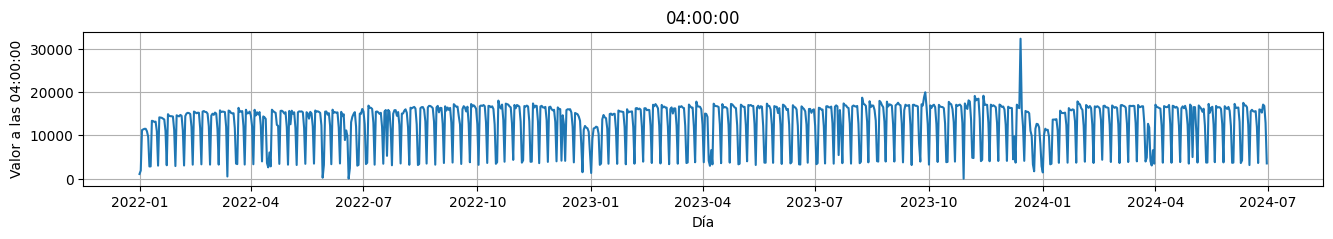

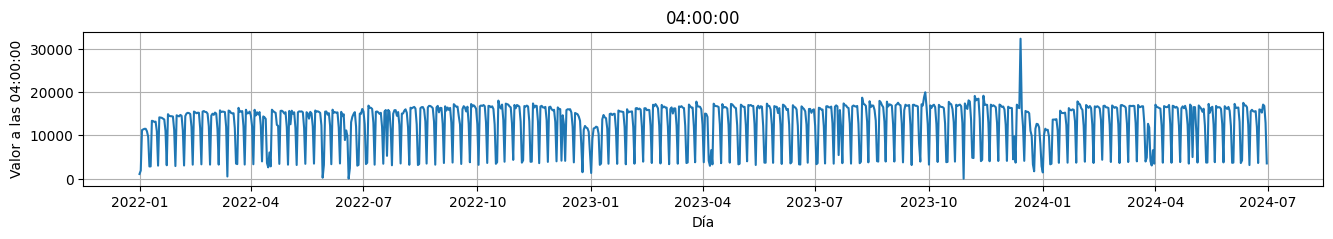

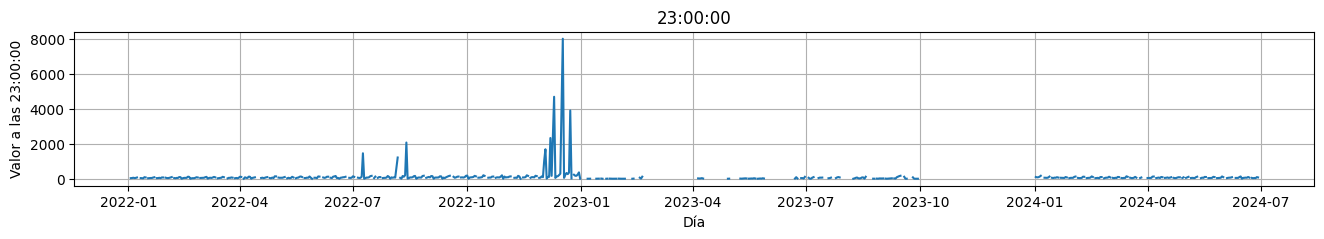

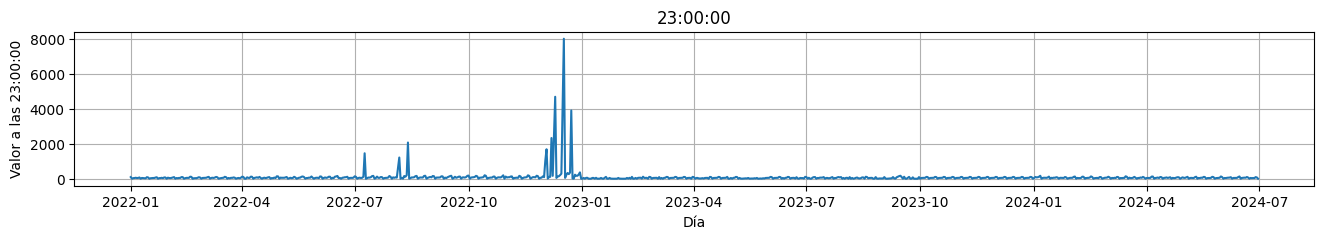

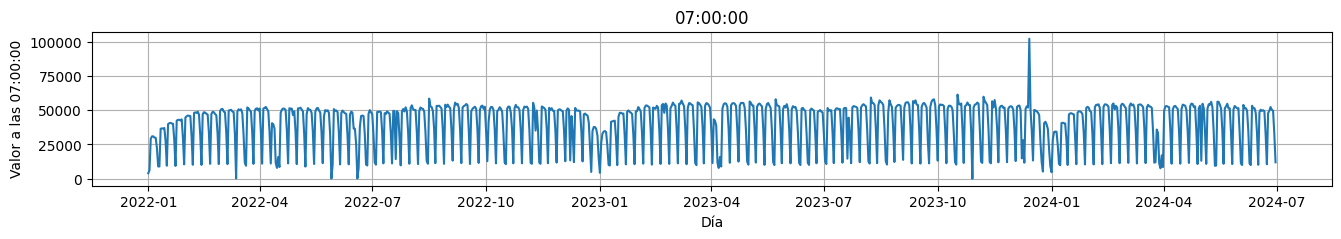

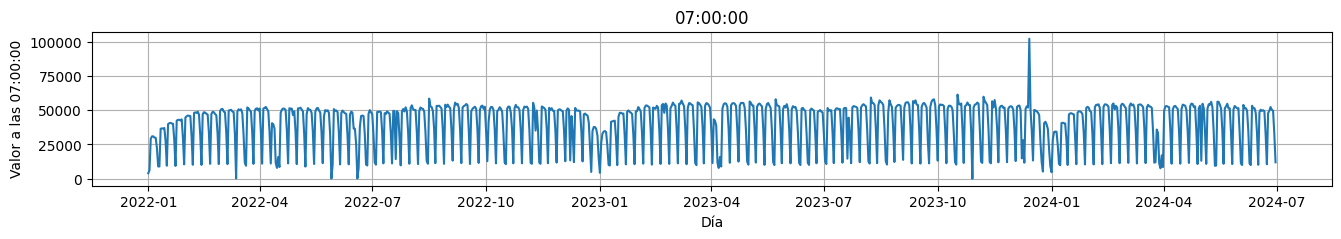

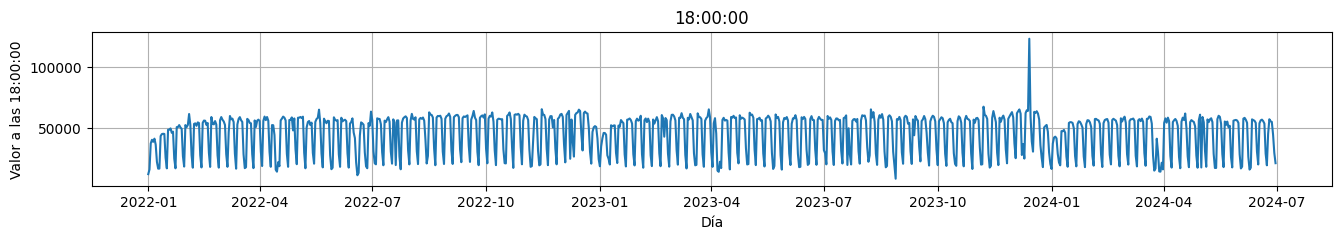

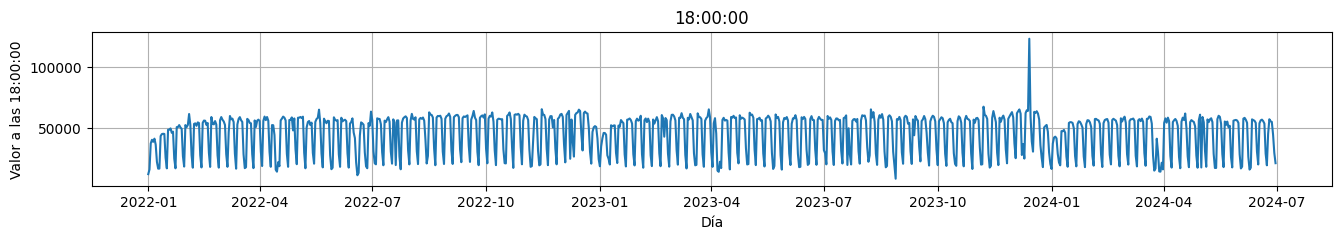

In [1162]:
def plot_serie(df, hour, log_scale=False):
    plt.figure(figsize=(16, 2))
    plt.plot(df['Día'], df[hour])
    plt.title(hour)
    plt.xlabel('Día')
    plt.ylabel(f'Valor a las {hour}')
    if log_scale:
        plt.yscale('log')  # Aplica la escala logarítmica al eje y    
    plt.grid(True)
    plt.show()

hour = '04:00:00'
plot_serie(data_linea_a_2019_2024, hour, log_scale=False)
plot_serie(data_linea_a_full, hour, log_scale=False)    

hour = '23:00:00'
plot_serie(data_linea_a_2019_2024, hour, log_scale=False)
plot_serie(data_linea_a_full, hour, log_scale=False)

hour = '07:00:00'
plot_serie(data_linea_a_2019_2024, hour, log_scale=False)
plot_serie(data_linea_a_full, hour, log_scale=False)

hour = '18:00:00'
plot_serie(data_linea_a_2019_2024, hour, log_scale=False)
plot_serie(data_linea_a_full, hour, log_scale=False)

In [1163]:
# 6. Eliminar tendencia y estacionalidad
descomposiciones_agrupadas = eliminar_tendencia_estacionalidad(data_linea_a_full, horas)

Usando descomposición multiplicativa para 04:00:00
Usando descomposición multiplicativa para 05:00:00
Usando descomposición multiplicativa para 06:00:00
Usando descomposición multiplicativa para 07:00:00
Usando descomposición multiplicativa para 08:00:00
Usando descomposición multiplicativa para 09:00:00
Usando descomposición multiplicativa para 10:00:00
Usando descomposición multiplicativa para 11:00:00
Usando descomposición multiplicativa para 12:00:00
Usando descomposición multiplicativa para 13:00:00
Usando descomposición multiplicativa para 14:00:00
Usando descomposición multiplicativa para 15:00:00
Usando descomposición multiplicativa para 16:00:00
Usando descomposición multiplicativa para 17:00:00
Usando descomposición multiplicativa para 18:00:00
Usando descomposición multiplicativa para 19:00:00
Usando descomposición multiplicativa para 20:00:00
Usando descomposición multiplicativa para 21:00:00
Usando descomposición multiplicativa para 22:00:00
Usando descomposición multiplic

In [1164]:
# 7. Detectar outliers en los residuos de la serie
outliers_residuos_agrupados = detectar_outliers_en_residuos(descomposiciones_agrupadas, umbral=1.5, data=data_linea_a_full)

# 8. Alinear los outliers con los datos originales
outliers_residuos_agrupados_aligned = data_linea_a_full[['Día']].merge(outliers_residuos_agrupados, on='Día', how='left').fillna(0)
outliers_residuos_agrupados_aligned_all = data_linea_a_full.merge(outliers_residuos_agrupados.add_suffix('_outlier'), on='Día', how='left').fillna(0)

outliers_residuos_agrupados_aligned_all.to_excel('results/full_2019_2024_data_linea_A_outliers.xlsx', index=False)

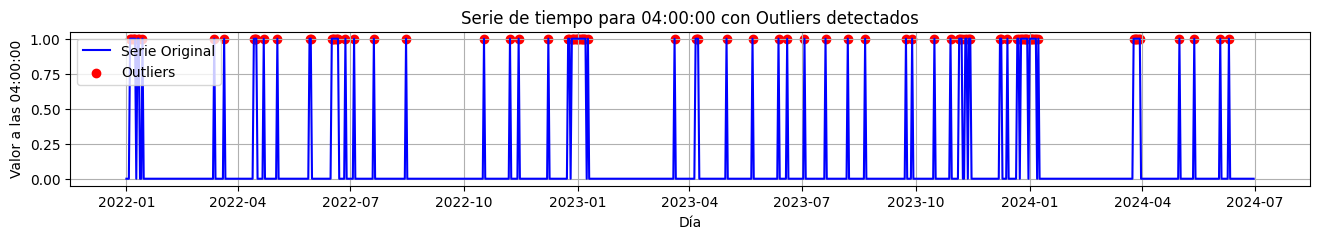

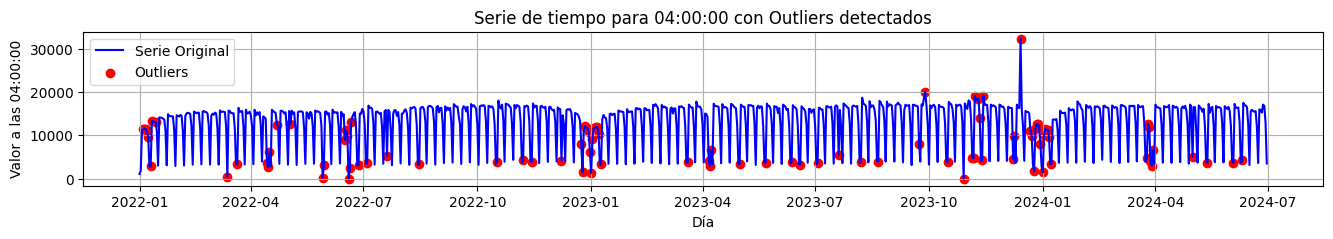

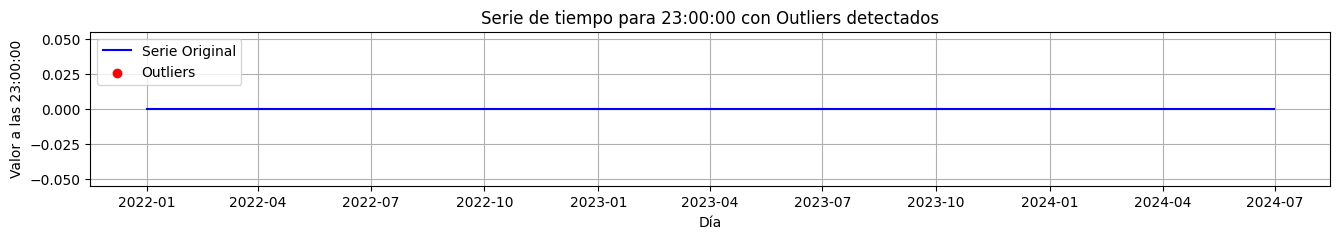

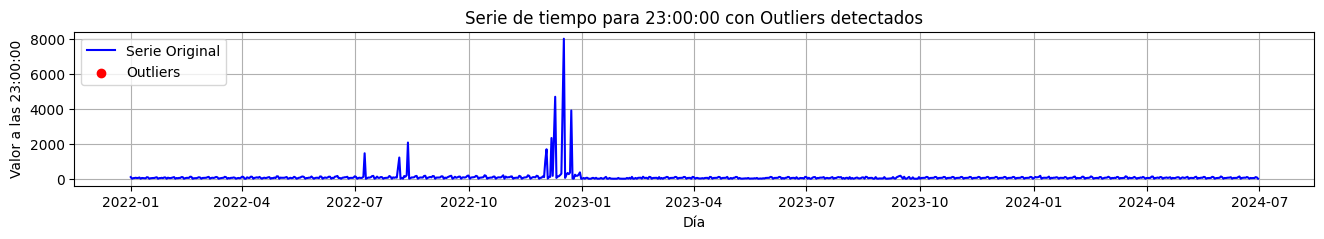

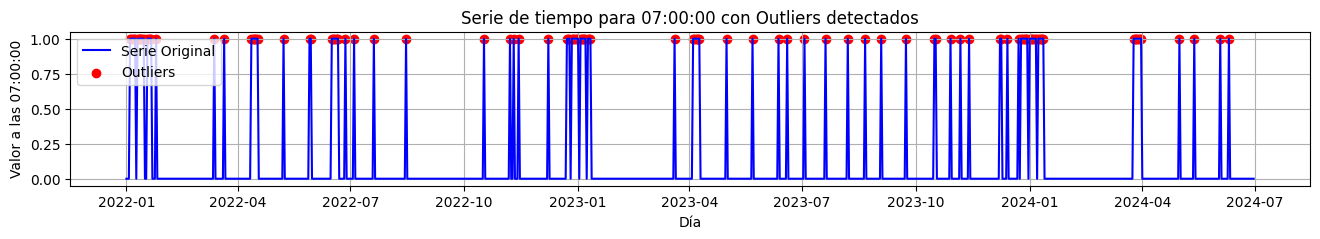

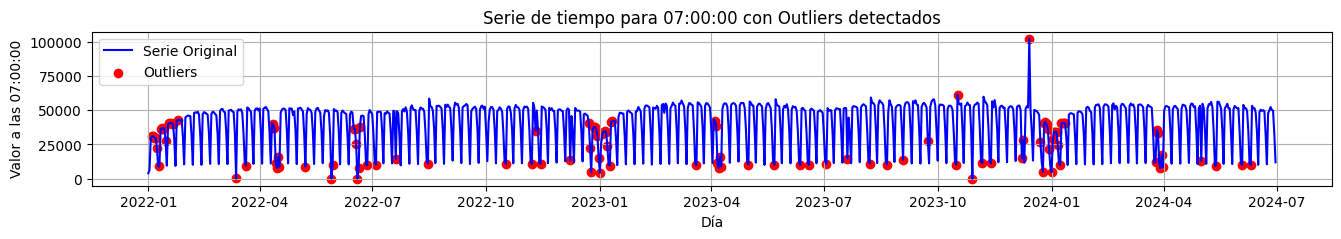

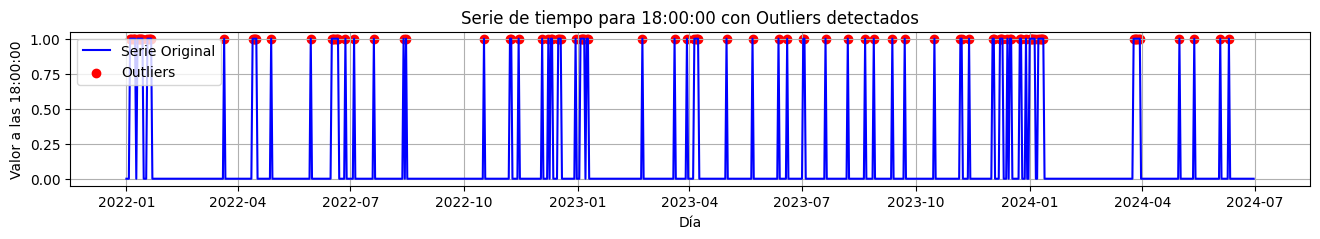

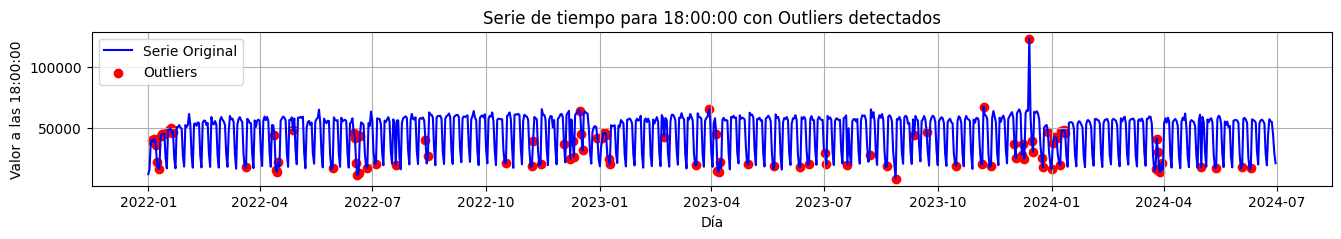

In [1165]:
def plot_serie_con_outliers(df, hora, outliers_residuos):
    plt.figure(figsize=(16, 2))
    plt.plot(df['Día'], df[hora], label='Serie Original', color='blue')
    outliers = outliers_residuos[hora] == 1
    plt.scatter(df['Día'][outliers], df[hora][outliers], color='red', label='Outliers')
    plt.title(f'Serie de tiempo para {hora} con Outliers detectados')
    plt.xlabel('Día')
    plt.ylabel(f'Valor a las {hora}')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

hour = '04:00:00'
plot_serie_con_outliers(outliers_residuos_agrupados_aligned, hour, outliers_residuos_agrupados_aligned)
plot_serie_con_outliers(data_linea_a_full, hour, outliers_residuos_agrupados_aligned)

hour = '23:00:00'
plot_serie_con_outliers(outliers_residuos_agrupados_aligned, hour, outliers_residuos_agrupados_aligned)
plot_serie_con_outliers(data_linea_a_full, hour, outliers_residuos_agrupados_aligned)

hour = '07:00:00'
plot_serie_con_outliers(outliers_residuos_agrupados_aligned, hour, outliers_residuos_agrupados_aligned)
plot_serie_con_outliers(data_linea_a_full, hour, outliers_residuos_agrupados_aligned)

hour = '18:00:00'
plot_serie_con_outliers(outliers_residuos_agrupados_aligned, hour, outliers_residuos_agrupados_aligned)
plot_serie_con_outliers(data_linea_a_full, hour, outliers_residuos_agrupados_aligned)

Any_Outlier_outlier
0.0                    686
1.0                    226
Name: count, dtype: int64

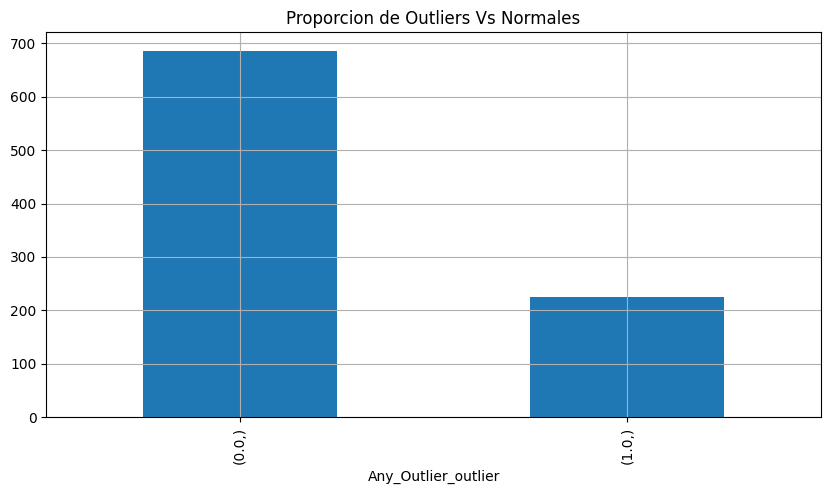

In [1166]:
outliers_residuos_agrupados_aligned_all[['Any_Outlier_outlier']].value_counts().plot(kind='bar', grid=True, figsize=(10,5), title="Proporcion de Outliers Vs Normales")
outliers_residuos_agrupados_aligned_all[['Any_Outlier_outlier']].value_counts()

In [1167]:
# 9. Conjuntos de train, test, eval

# Seleccionamos registros normales (Any_Outlier == 0) y registros con outliers (Any_Outlier == 1)
normales = outliers_residuos_agrupados_aligned_all[outliers_residuos_agrupados_aligned_all['Any_Outlier_outlier'] == 0][horas]
outliers = outliers_residuos_agrupados_aligned_all[outliers_residuos_agrupados_aligned_all['Any_Outlier_outlier'] == 1][horas]

# 2. Creamos el conjunto de train solo con registros normales (80% para entrenamiento)
train_normales, restantes_normales = train_test_split(normales, test_size=0.3)

# 3. Ahora creamos los conjuntos de test y val con registros que contengan outliers
# Dividimos los registros con outliers en test y val
outliers_test_val, outliers_test = train_test_split(outliers, test_size=0.5)

# 4. Seleccionamos una pequeña porción de registros normales (de los que quedaron) para test y val
normales_test_val, normales_test = train_test_split(restantes_normales, test_size=0.5)

# 5. Finalmente, combinamos los registros de outliers y normales en test y val
# Aseguramos que los registros con outliers tengan Any_Outlier = 1
outliers_test['Any_Outlier_outlier'] = 1
outliers_test_val['Any_Outlier_outlier'] = 1

# Aseguramos que los registros normales tengan Any_Outlier = 0
normales_test['Any_Outlier_outlier'] = 0
normales_test_val['Any_Outlier_outlier'] = 0

# test = pd.concat([outliers_test, normales_test]).sample(frac=1, random_state=42)  # Mezclamos las filas para test
test = normales_test.sample(frac=1, random_state=42)  # Mezclamos las filas para test
val = pd.concat([outliers_test_val, normales_test_val]).sample(frac=1, random_state=42)  # Mezclamos las filas para val

# Verificamos el tamaño de los conjuntos
print(f"Train size (normal only): {train_normales.shape}")
print(f"Test size (outliers and normal): {test.shape}")
print(f"Validation size (outliers and normal): {val.shape}")

Train size (normal only): (480, 20)
Test size (outliers and normal): (103, 21)
Validation size (outliers and normal): (216, 21)


In [1168]:
# 10. Normalizar los datos
scaler = MinMaxScaler()

# Ajustamos el escalador en el conjunto de entrenamiento (solo registros normales)
train_normales_scaled = scaler.fit_transform(outliers_residuos_agrupados_aligned_all[horas])

# Aplicamos la transformación (sin ajustar) a los conjuntos de test y val

test_scaled = scaler.transform(train_normales)
test_scaled = scaler.transform(test.drop(['Any_Outlier_outlier'], axis=1))
val_scaled = scaler.transform(val.drop(['Any_Outlier_outlier'], axis=1))

# Verificamos el tamaño de los conjuntos escalados
print(f"Train size (normal only, scaled): {train_normales_scaled.shape}")
print(f"Test size (outliers and normal, scaled): {test_scaled.shape}")
print(f"Validation size (outliers and normal, scaled): {val_scaled.shape}")

Train size (normal only, scaled): (912, 20)
Test size (outliers and normal, scaled): (103, 20)
Validation size (outliers and normal, scaled): (216, 20)


In [1169]:
# 11. Entrenar el autoencoder
input_dim = train_normales_scaled.shape[1]
autoencoder, history = entrenar_autoencoder(train_normales_scaled, test_scaled, input_dim)

Epoch 1/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1387 - val_loss: 0.1043
Epoch 2/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1230 - val_loss: 0.0867
Epoch 3/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1084 - val_loss: 0.0763
Epoch 4/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0952 - val_loss: 0.0667
Epoch 5/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0788 - val_loss: 0.0595
Epoch 6/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0658 - val_loss: 0.0527
Epoch 7/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0536 - val_loss: 0.0457
Epoch 8/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0474 - val_loss: 0.0407
Epoch 9/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0432 - val_loss: 0.0384
Epoch 10/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0405 - val_loss: 0.0357
Epoch 11/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0375 - val_loss: 0.0341
Epoch 12/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

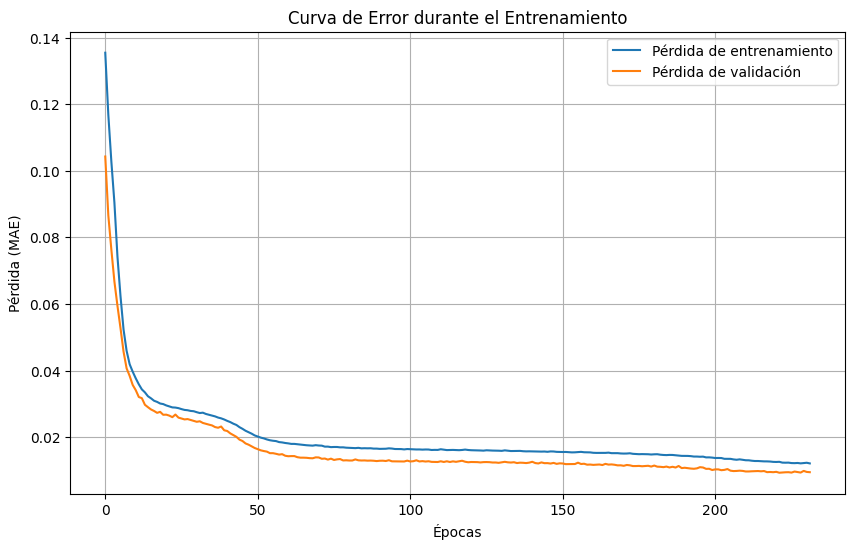

In [1170]:
# 12. Graficar la curva de error durante el entrenamiento
graficar_curva_entrenamiento(history)

In [1171]:
autoencoder.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_67 (InputLayer)     │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 16)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 20)             │           340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,098 (12.11 KB)

 Trainable params: 1,032 (4.03 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,066 (8.07 KB)

In [1172]:
# 13. Evaluar el modelo y graficar la curva ROC
outlier_labels = val['Any_Outlier_outlier'].values
threshold, errors = evaluar_autoencoder(autoencoder, val_scaled, val.drop(['Any_Outlier_outlier'], axis=1), scaler, outlier_labels, umbral=0.5)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [1173]:
print(f"El Threshold es: {int(np.round(threshold,0))}")

El Threshold es: 827


In [1174]:
# 14. Calcular las métricas de evaluación con el umbral y mostrar la distribución de errores
predictions = (errors > threshold).astype(int)

accuracy = accuracy_score(outlier_labels, predictions)
precision = precision_score(outlier_labels, predictions)
recall = recall_score(outlier_labels, predictions)
f1 = f1_score(outlier_labels, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.77
Precision: 0.77
Recall: 0.81
F1-Score: 0.79


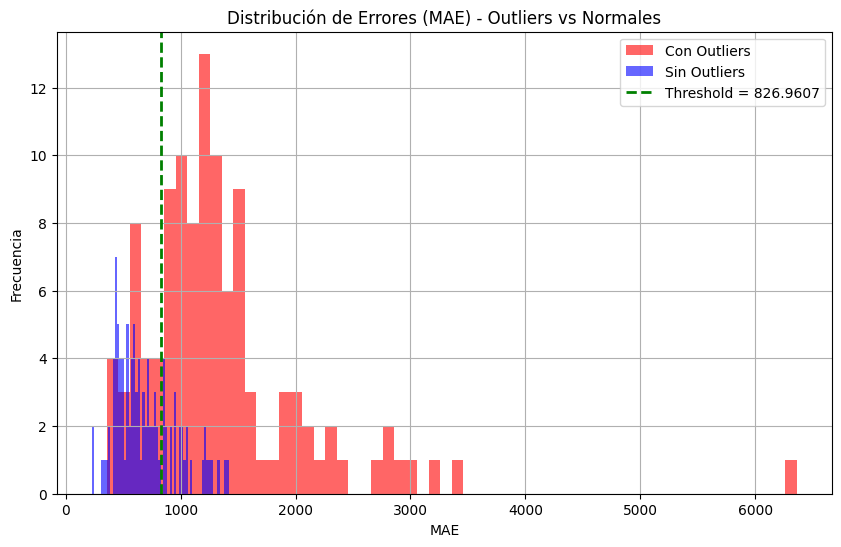

In [1175]:
# 15. Graficar la distribución de los errores con el umbral
plt.figure(figsize=(10, 6))
plt.hist(errors[outlier_labels == 1], bins=60, alpha=0.6, label='Con Outliers', color='red')
plt.hist(errors[outlier_labels == 0], bins=60, alpha=0.6, label='Sin Outliers', color='blue')
plt.axvline(threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold = {threshold:.4f}')
plt.title('Distribución de Errores (MAE) - Outliers vs Normales')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.savefig(f'./results/tf_modelo_{int(accuracy*100)}_{int(recall*100)}_{int(f1*100)}_grafico.png')
plt.show()

In [1176]:
# Guardar el modelo completo
autoencoder.save(f'./results/tf_modelo_{int(accuracy*100)}_{int(recall*100)}_{int(f1*100)}.h5')
autoencoder.save(f'./results/tf_modelo_{int(accuracy*100)}_{int(recall*100)}_{int(f1*100)}.keras')

# Guardar el valor del threshold en un archivo .yml
filename = f'./results/tf_modelo_{int(accuracy*100)}_{int(recall*100)}_{int(f1*100)}_threshold.yml'
data = {'threshold': int(np.round(threshold,0))}

with open(filename, 'w') as file:
    yaml.dump(data, file)

# Guardar el scaler entrenado en un archivo
scaler_filename = f'./results/scaler_{int(accuracy*100)}_{int(recall*100)}_{int(f1*100)}.pkl'
joblib.dump(scaler, scaler_filename)

['./results/scaler_77_81_78.pkl']

c:\Users\SEBASTIAN\Documents\Github Projects\Python\AutoencoderMetroAnomalyApp\env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


c:\Users\SEBASTIAN\Documents\Github Projects\Python\AutoencoderMetroAnomalyApp\env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


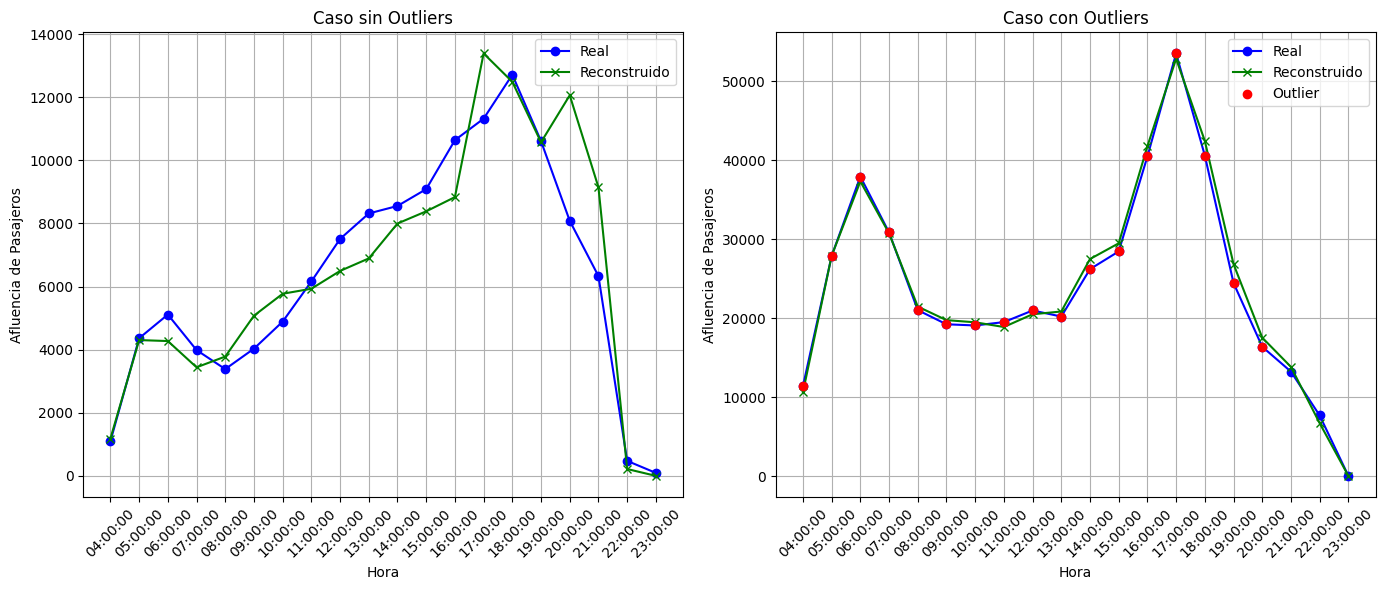

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


c:\Users\SEBASTIAN\Documents\Github Projects\Python\AutoencoderMetroAnomalyApp\env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\SEBASTIAN\Documents\Github Projects\Python\AutoencoderMetroAnomalyApp\env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


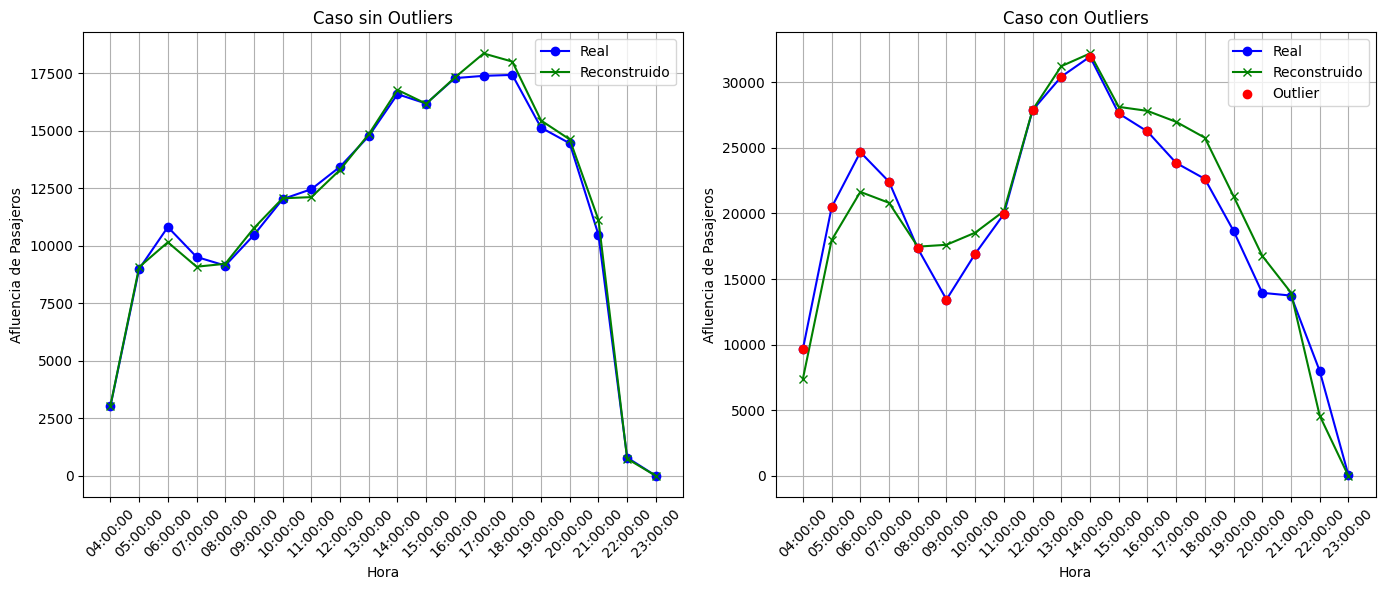

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\SEBASTIAN\Documents\Github Projects\Python\AutoencoderMetroAnomalyApp\env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\SEBASTIAN\Documents\Github Projects\Python\AutoencoderMetroAnomalyApp\env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


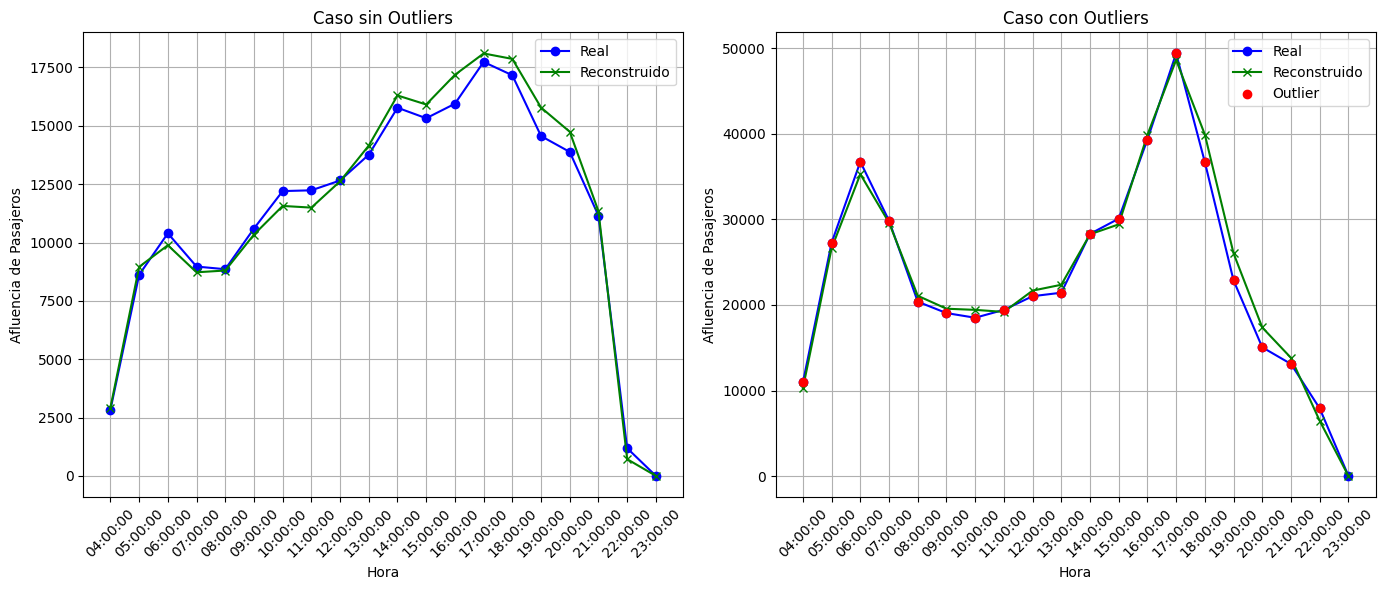

c:\Users\SEBASTIAN\Documents\Github Projects\Python\AutoencoderMetroAnomalyApp\env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


c:\Users\SEBASTIAN\Documents\Github Projects\Python\AutoencoderMetroAnomalyApp\env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


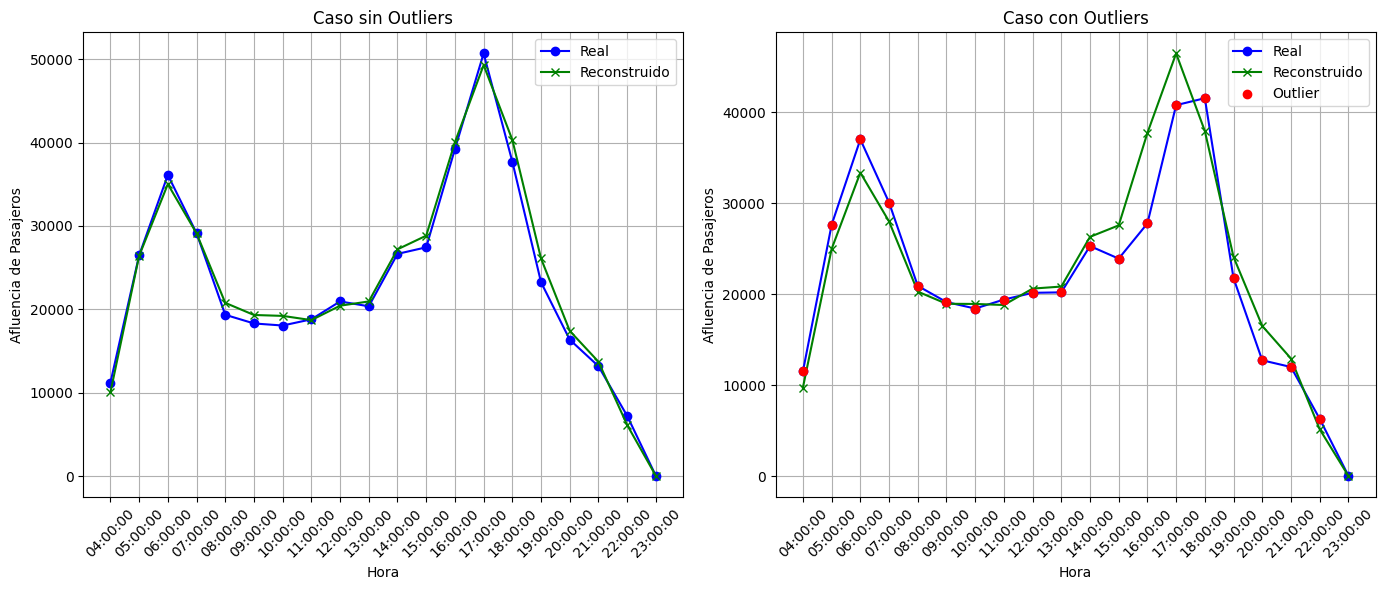

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

c:\Users\SEBASTIAN\Documents\Github Projects\Python\AutoencoderMetroAnomalyApp\env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\SEBASTIAN\Documents\Github Projects\Python\AutoencoderMetroAnomalyApp\env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


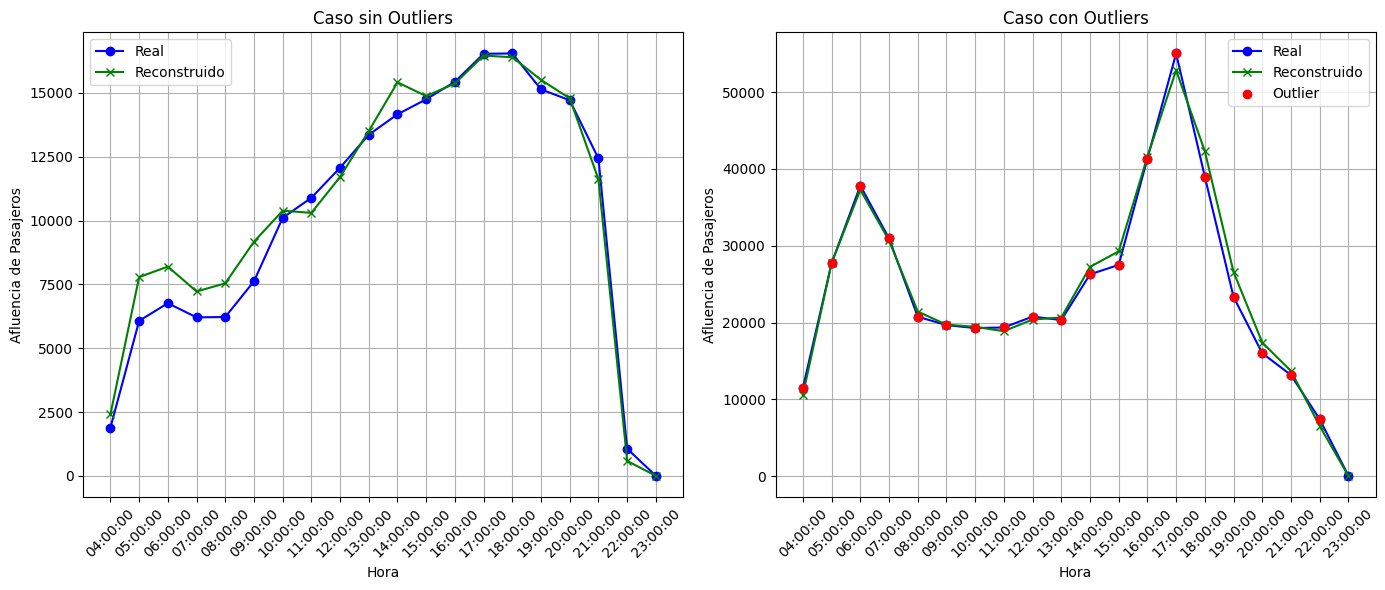

In [1177]:
# 16. Visualizar algunas predicciones con y sin outliers
days_to_see = np.random.choice(5, size=5, replace=False)
for day in days_to_see:
  # graficar_casos_outliers_vs_normales(autoencoder, scaler, val, horas, n=day)
  graficar_casos_outliers_vs_normales(autoencoder, scaler, outliers_residuos_agrupados_aligned_all, horas, n=day)
  plt.show()

In [1178]:
# 17. Aumentar el conjunto de datos de evaluacion
def crear_dataset_con_ventanas(data, horas, tamaño_ventana=20):
    dataset_ventanas = []
    
    # Iteramos sobre los días
    for dia in range(len(data) - 1):
        # Creamos un deque para las ventanas
        deque_ventanas = deque(maxlen=tamaño_ventana)
        
        # Obtenemos las horas del día actual y el siguiente
        dia_actual = data.iloc[dia][horas].values
        dia_siguiente = data.iloc[dia + 1][horas].values
        
        # Cargamos la ventana completa inicial del día actual
        deque_ventanas.extend(dia_actual)
        
        # Deslizamos la ventana por el día actual y el siguiente
        for i in range(len(horas)):
            # Guardamos una copia de la ventana actual
            dataset_ventanas.append(list(deque_ventanas))
            
            # Desplazamos: quitamos la primera hora y añadimos la primera del día siguiente
            if i < len(horas) - 1:
                deque_ventanas.append(dia_siguiente[i])
    
    return pd.DataFrame(dataset_ventanas, columns=[f'Hora_{i}' for i in range(tamaño_ventana)])

def visualizar_ventanas(dataset_ventanas, inicio=0, num_ventanas=6):
    # Filtramos las ventanas que se quieren graficar y las transponemos para visualización
    dataset_ventanas.iloc[inicio:inicio + num_ventanas, :].T.plot(figsize=(16, 5), grid=True, marker='o')
    plt.title(f'Visualización de {num_ventanas} ventanas deslizantes a partir del índice {inicio}')
    plt.xlabel('Hora en la ventana')
    plt.ylabel('Afluencia')
    plt.legend(title='Ventanas')
    plt.show()

In [1179]:
# Crear dataset con ventanas deslizantes para días normales y días con outliers
dataset_ventanas_normales = crear_dataset_con_ventanas(val[val['Any_Outlier_outlier'] == 0], horas)
dataset_ventanas_outliers = crear_dataset_con_ventanas(val[val['Any_Outlier_outlier'] == 1], horas)

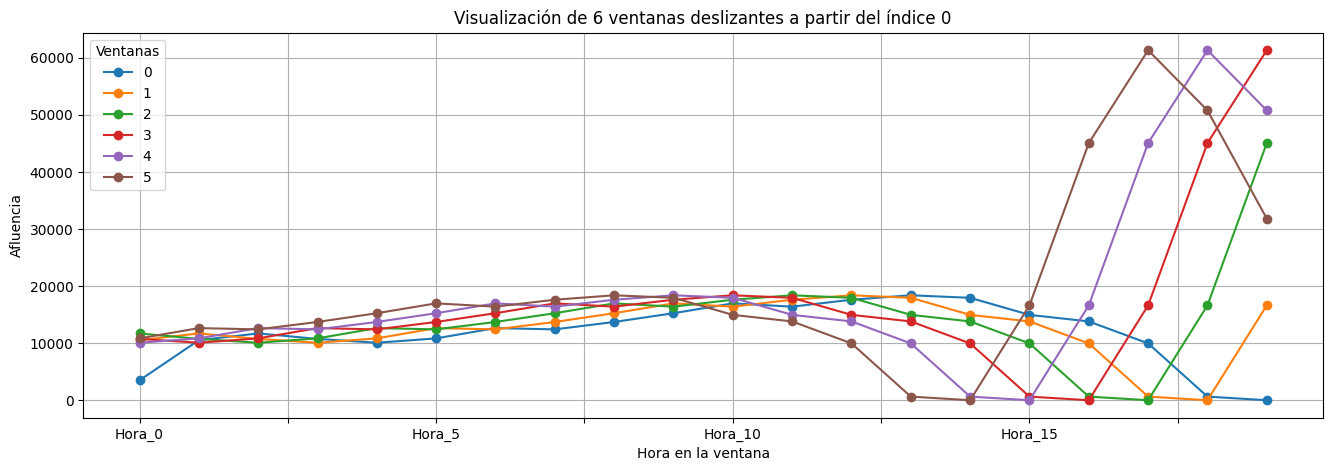

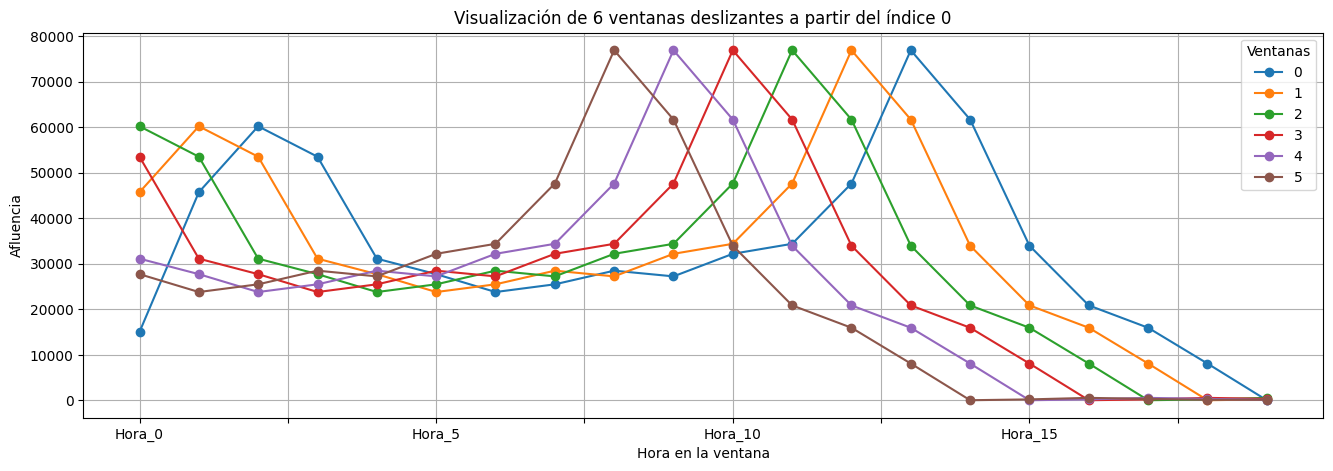

In [1180]:
visualizar_ventanas(dataset_ventanas_normales, inicio=((20 * 0)), num_ventanas=6)
visualizar_ventanas(dataset_ventanas_outliers, inicio=((20 * 0)), num_ventanas=6)

In [1181]:
dataset_ventanas_normales.columns = val.drop(['Any_Outlier_outlier'], axis=1).columns
dataset_ventanas_outliers.columns = val.drop(['Any_Outlier_outlier'], axis=1).columns

In [1182]:
# Datos con ventanas moviles (Problema: El scaler solo conoce un orden)

# dataset_ventanas_normales_scaled = scaler.transform(dataset_ventanas_normales)
# dataset_ventanas_outliers_scaled = scaler.transform(dataset_ventanas_outliers)

# for idx, registro in enumerate(dataset_ventanas_normales_scaled):
#     dump(registro, open(f'./data_test/x_test_normal_{idx+1}.pkl', 'wb'))

# for idx, registro in enumerate(dataset_ventanas_outliers_scaled):
#     dump(registro, open(f'./data_test/x_test_outlier_{idx+1}.pkl', 'wb'))

In [1183]:
df_normales_test_val = pd.DataFrame(normales_test_val, columns=val.drop(['Any_Outlier_outlier'], axis=1).columns)
df_outliers_test_val = pd.DataFrame(outliers_test_val, columns=val.drop(['Any_Outlier_outlier'], axis=1).columns)

In [1184]:
dataset_normales_scaled = scaler.transform(df_normales_test_val)
dataset_outliers_scaled = scaler.transform(df_outliers_test_val)

for idx, registro in enumerate(dataset_normales_scaled):
    dump(registro, open(f'./data_test/x_test_normal_{idx+1}.pkl', 'wb'))

for idx, registro in enumerate(dataset_outliers_scaled):
    dump(registro, open(f'./data_test/x_test_outlier_{idx+1}.pkl', 'wb'))

# FIN
---